In [1]:
import os
import starfile
import mrcfile
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


In [3]:
meta_refine026 = starfile.read('20s_10025/Refine3D/job026/run_data.star')
meta_recenter = starfile.read('20s_10025/Extract/job011/particles.star')
image_idx = 1999
imageName = meta_recenter['rlnImageName'][image_idx]
refine026 = meta_refine026[meta_refine026['rlnImageName'] == imageName]#[['rlnAngleRot', 'rlnAngleTilt','rlnAnglePsi', 'rlnOriginX', 'rlnOriginY']].iloc[0]

In [4]:
particle_idx = int(imageName.split("@")[0]) -1
image_path = imageName.split('@')[1]
print(image_path)
with mrcfile.open(f'20s_10025/{image_path}') as mrc:
    mrc_stack_recenter = mrc.data[particle_idx]
    mrc_stack_recenter_gs = gaussian_filter(mrc_stack_recenter, sigma=5)

Extract/job011/mrc/14sep05c_c_00007gr_00013sq_00019hl_00002es_c.mrcs


In [5]:
mask_path = "20s_10025/MaskCreate/job029/mask.mrc"
refine_path = "20s_10025/Refine3D/job026/run_class001.mrc"
output_path_mask = "mask_proj.mrc"
output_path_refine = "refine_proj.mrc"
rot = float(refine026['rlnAngleRot'])
tilt = float(refine026['rlnAngleTilt'])
psi = float(refine026['rlnAnglePsi'])
xoff = float(refine026['rlnOriginX'])
yoff = float(refine026['rlnOriginY'])

In [6]:
os.system(f'relion_project \
            --i {mask_path} --o {output_path_mask}\
            --rot {rot} --tilt {tilt}\
            --psi {psi} --xoff {xoff}\
            --yoff {yoff}')
os.system(f'relion_project \
            --i {refine_path} --o {output_path_refine}\
            --rot {rot} --tilt {tilt}\
            --psi {psi} --xoff {xoff}\
            --yoff {yoff}')

 Reading map: 20s_10025/MaskCreate/job029/mask.mrc


         The value in the input image header (= 0.66) is used instead.


 Done reading map!
 Done writing mask_proj.mrc
 Reading map: 20s_10025/Refine3D/job026/run_class001.mrc
 Done reading map!


         The value in the input image header (= 0.66) is used instead.


 Done writing refine_proj.mrc


0

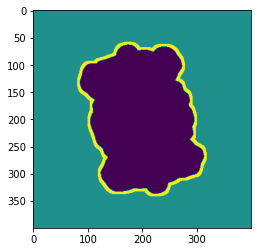

In [8]:
threshold = 10
with mrcfile.open(output_path_mask) as mrc:
    mask_proj = mrc.data
with mrcfile.open(output_path_refine) as mrc:
    refine_proj  = mrc.data
mask_proj.setflags(write=1)
mask_proj[mask_proj <= threshold] = 2
mask_proj[mask_proj > threshold] = 1
import numpy as np
from scipy.ndimage import convolve

fil = np.full((11,11), -1)
fil[5,5] = 11*11-1
contour = convolve(mask_proj, fil, mode='reflect') > 0
mask_proj[contour == True] = 3
mask_proj = mask_proj.astype('uint8')
plt.imshow(mask_proj)
with mrcfile.open(output_path_mask) as mrc:
    mask_proj_raw = mrc.data


(1.0, 3.0)

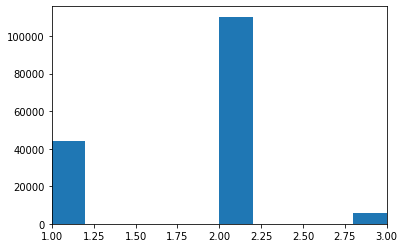

In [9]:
fig, ax = plt.subplots(1,1)
ax.hist(mask_proj.ravel(), range=(mask_proj.min(),mask_proj.max()))
ax.set_xlim(mask_proj.min(),mask_proj.max())

(-0.5, 399.5, 399.5, -0.5)

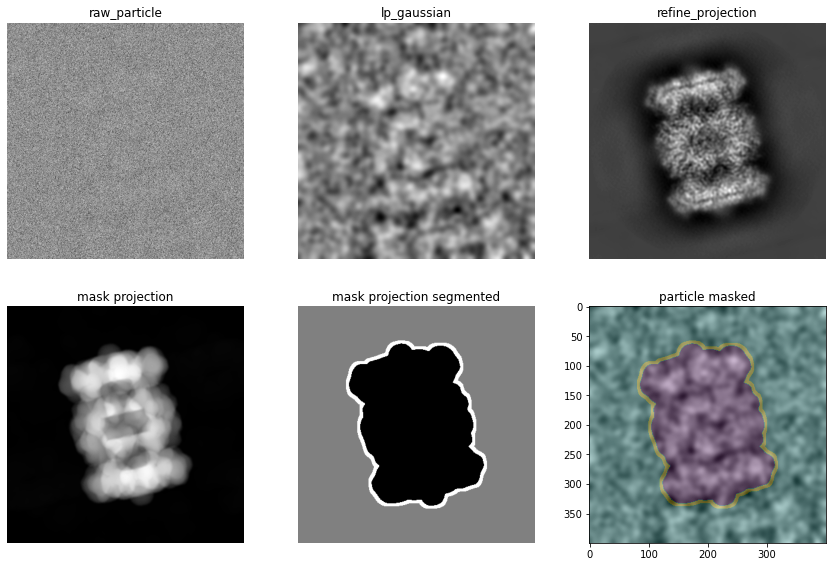

In [10]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot(4,4,1)
ax1.set_title('raw_particle')
plt.imshow(mrc_stack_recenter, cmap='gray')
ax1.axis('off')

ax2 = plt.subplot(4,4,2)
ax2.set_title('lp_gaussian')
plt.imshow(mrc_stack_recenter_gs, cmap='gray')
ax2.axis('off')

ax2_1 = plt.subplot(4,4,3)
ax2_1.set_title('refine_projection')
plt.imshow(refine_proj, cmap='gray')
ax2_1.axis('off')

ax3 = plt.subplot(4,4,5)
ax3.set_title('mask projection')
plt.imshow(mask_proj_raw, cmap='gray')
ax3.axis('off')

ax4 = plt.subplot(4,4,6)
ax4.set_title('mask projection segmented')
plt.imshow(mask_proj, cmap='gray')
ax4.axis('off')

ax5 = plt.subplot(4,4,7)
ax5.set_title('particle masked')
plt.imshow(mrc_stack_recenter_gs, cmap='gray')
plt.imshow(mask_proj, alpha=0.3)
ax4.axis('off')

In [67]:
print(f'{particle_idx}@{image_path.split("/")[-1]}')

47@14sep05c_c_00007gr_00013sq_00019hl_00002es_c.mrcs
